<span>Licence CC-BY-NC-SA: </span>
**Alexandre Jayol & Christophe Tettarassar**

Mars 2022

# **UE TES**
## **Atelier Mobilité Durable**

### **MODULE 2**: Recherche visant à optimiser les émissions de polluants à partir de données GNSS
### **TD n°2**: Evaluation des émissions de polluants des itinéraires et recherche d'itinéraires alternatifs moins polluant

### **SOMMAIRE**

[1. Partie 1](#section_1)<br>
&emsp;&emsp;[1.0 Modèle d'émissions COPERT](#section_10)<br>
&emsp;&emsp;[1.1 Estimation des émissions des trajets issus de Symuvia](#section_11)<br>
&emsp;&emsp;[1.2 Evaluation des gains des éco-itinéraires](#section_12)<br>

##### **0.0 Import des modules**

In [1]:
############################################################################################################################
#import module
############################################################################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
from shapely.geometry import shape, MultiLineString, LineString, Point
import warnings
warnings.filterwarnings('ignore')

<a id='section_1'></a>
#### <u>**1. Partie 1**

<a id='section_10'></a>
##### **1.0 Modèle d'émissions COPERT**

On importe différents facteurs d'émission pour visualiser ce qu'ils représentent.

In [2]:
###########################################################################################################################
# Import des facteurs d'émissions provenant du modèle d'émission COPERT
###########################################################################################################################

###############################################################################################
# Import du fichier csv que l'on stocke dans copert
copert = pd.read_csv("Data Partie 1/copert.csv", header=0, sep=";", decimal=",")

display(copert.info())
display(copert)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 11 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   speedInKph                                   123 non-null    int64  
 1   Emission (g/km) Légers_CO2                   123 non-null    float64
 2   Emission (g/km) Large-SUV_CO2_Diesel_Euro5   123 non-null    float64
 3   Emission (g/km) Légers_CO2_Diesel_Euro4      123 non-null    float64
 4   Emission (g/km) Légers_CO2_Diesel_Euro5      123 non-null    float64
 5   Emission (g/km) Légers_CO2_Petrol_Euro5      123 non-null    float64
 6   Emission (g/km) Légers_PM10                  123 non-null    float64
 7   Emission (g/km) Large-SUV_PM10_Diesel_Euro5  123 non-null    float64
 8   Emission (g/km) Légers_PM10_Diesel_Euro4     123 non-null    float64
 9   Emission (g/km) Légers_PM10_Diesel_Euro5     123 non-null    float64
 10  Em

None

,speedInKph,Emission (g/km) Légers_CO2,Emission (g/km) Large-SUV_CO2_Diesel_Euro5,Emission (g/km) Légers_CO2_Diesel_Euro4,Emission (g/km) Légers_CO2_Diesel_Euro5,Emission (g/km) Légers_CO2_Petrol_Euro5,Emission (g/km) Légers_PM10,Emission (g/km) Large-SUV_PM10_Diesel_Euro5,Emission (g/km) Légers_PM10_Diesel_Euro4,Emission (g/km) Légers_PM10_Diesel_Euro5,Emission (g/km) Légers_PM10_Petrol_Euro5
0,1,343.902041,347.593959,251.251798,251.251798,346.745316,0.017308,0.005051,0.039958,0.005051,0.002347
1,2,343.902041,347.593959,251.251798,251.251798,346.745316,0.017308,0.005051,0.039958,0.005051,0.002347
2,3,343.902041,347.593959,251.251798,251.251798,346.745316,0.017308,0.005051,0.039958,0.005051,0.002347
3,4,343.902041,347.593959,251.251798,251.251798,346.745316,0.017308,0.005051,0.039958,0.005051,0.002347
4,5,343.902041,347.593959,251.251798,251.251798,346.745316,0.017308,0.005051,0.039958,0.005051,0.002347
...,...,...,...,...,...,...,...,...,...,...,...
118,119,191.719899,218.895069,153.408027,153.408027,159.504400,0.016399,0.001417,0.030139,0.001417,0.002426
119,120,193.216793,220.805382,154.933323,154.933323,160.169300,0.016532,0.001413,0.030432,0.001413,0.002550
120,121,194.759819,222.764369,156.537740,156.537740,160.835590,0.016669,0.001409,0.030732,0.001409,0.002681
121,122,196.364314,224.773084,158.226370,158.226370,161.503105,0.016808,0.001405,0.031038,0.001405,0.002819


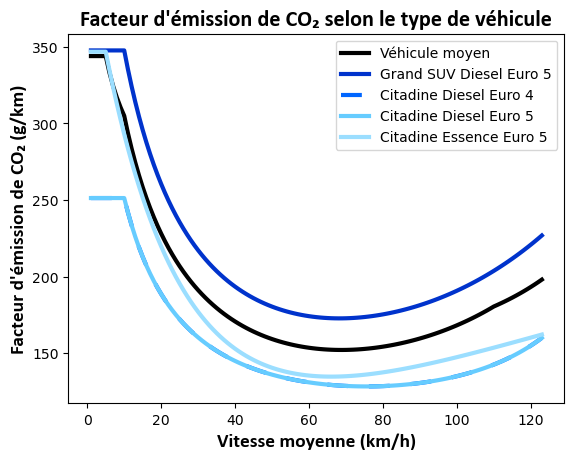

In [3]:
######################################################################################################################
# Plot distribution of Emission target gain
plt.clf()
plt.close("all")
fig = plt.figure()
paper_rc = {'lines.linewidth': 3}
colors=["k","#0033CC","#0066FF","#66CCFF","#9BDEFF"]
labels = ['Véhicule moyen','Grand SUV Diesel Euro 5','Citadine Diesel Euro 4','Citadine Diesel Euro 5','Citadine Essence Euro 5']
for i, label, color in zip(range(1,6), labels, colors):
    if i == 3:
        plt.plot(copert.iloc[:,0], copert.iloc[:,i], label=label, color=color, linewidth=3, linestyle=(0, (5, 5)))
    else:
        plt.plot(copert.iloc[:,0], copert.iloc[:,i], label=label, color=color, linewidth=3)

plt.title("Facteur d'émission de CO\u2082 selon le type de véhicule", fontsize = 16, fontweight="bold", fontname="calibri")
plt.xlabel("Vitesse moyenne (km/h)", fontsize = 14, fontweight="bold", fontname="calibri")
plt.ylabel("Facteur d'émission de CO\u2082 (g/km)", fontsize = 14, fontweight="bold", fontname="calibri")
plt.legend()
plt.show()

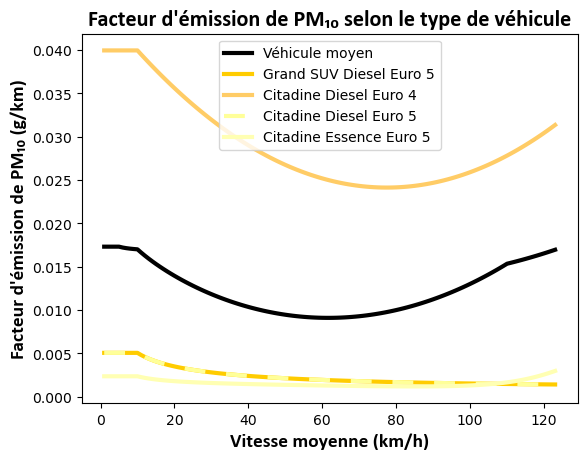

In [4]:
######################################################################################################################
# Plot distribution of Emission target gain
plt.clf()
plt.close("all")
fig = plt.figure()
paper_rc = {'lines.linewidth': 3}
colors=["k","#FFCC00","#FFCC66","#FFFF99","#FFFFB3"]
labels = ['Véhicule moyen','Grand SUV Diesel Euro 5','Citadine Diesel Euro 4','Citadine Diesel Euro 5','Citadine Essence Euro 5']
for i, label, color in zip(range(6,11), labels, colors):
    if i == 9:
        plt.plot(copert.iloc[:,0], copert.iloc[:,i], label=label, color=color, linewidth=3, linestyle=(0, (5, 5)))
    else:
        plt.plot(copert.iloc[:,0], copert.iloc[:,i], label=label, color=color, linewidth=3)

plt.title("Facteur d'émission de PM\u2081\u2080 selon le type de véhicule", fontsize = 16, fontweight="bold", fontname="calibri")
plt.xlabel("Vitesse moyenne (km/h)", fontsize = 14, fontweight="bold", fontname="calibri")
plt.ylabel("Facteur d'émission de PM\u2081\u2080 (g/km)", fontsize = 14, fontweight="bold", fontname="calibri")
plt.legend()
plt.show()

##### **Exercice 1**<br>
Q1.1. De quoi dépendent les facteurs d'émissions fournis par le modèle d'émission COPERT?

- du type de polluant
- du type de véhicule (citadine, SUV, etc.)
- du type de carburant

En réalité, les facteurs d'émissions sont des valeurs discrètes et non continues. Ces facteurs ont été obtenus en utilisant des méthodes statistiques.<br>
Pour obtenir les facteurs d'émissions brutes, des expérimentations ont eu lieu sur plusieurs types de véhicule avec différents cycles de conduite.

<div class="alert-warning">
    <b>Dans la suite du TD, nous nous limiterons à l'étude du CO<sub>2</sub> pour un véhicule moyen (du parc routier de 2017).<b>
</div>

In [5]:
######################################################################################################################
# Sélection du facteur d'émission CO2 pour un véhicule moyen
copert = copert[["speedInKph", "Emission (g/km) Légers_CO2"]]

<a id='section_11'></a>
##### **1.1 Estimation des émissions des trajets issus de Symuvia**

In [20]:
############################################################################################################################
# Import des données du réseau routier depuis un fichier csv
############################################################################################################################
file_path_network_l63v = "Data Partie 1/reseau_L63V_AJ_vf.csv"
network_l63v = pd.read_csv(file_path_network_l63v, header=0, sep=";", decimal=",", usecols=['id', 'eltamont', 'eltaval', 'geometry', 'lgmvtaval', 'vit_reg'])


############################################################################################################################
# Import des itinéraires simulés depuis un fichier zip
############################################################################################################################
Simu_Trip = pd.DataFrame()
for j in range(0,5):
    print(j)
    file_path_Simu_Trip = "Data Partie 1/Trip simulés_jour 0_part"+str(j)+".zip"
    Simu_Trip_tmp = pd.read_csv(file_path_Simu_Trip, header = 0, decimal=',', sep=';')
    Simu_Trip = pd.concat([Simu_Trip, Simu_Trip_tmp])
print(len(Simu_Trip["Vehid"].unique()))
Simu_Trip["creation"] = Simu_Trip["creation"].astype('Float64')
Simu_Trip = pd.merge(Simu_Trip.drop(['lgmvtaval'], axis=1), network_l63v[["id", "lgmvtaval"]], how='inner', left_on='LinkId', right_on='id', validate="m:1")
Simu_Trip.sort_values(["Vehid", "TT (s)_cumsum"], inplace=True)

0
1
2
3
4
84627


In [21]:
Simu_Trip

,Unnamed: 0,index,Vehid,origin,typeofvehicle,creation,destination,period,LinkId,vitesse_spatiale,vitesse_spatiale (km/h),TT (s),lgmvtaval_cumsum,TT (s)_cumsum,id,lgmvtaval
0,0,0,6,C_82620999,VL,1.894,C_82612264,1,T_711811472_FRef,11.160,40,15.240150,169.3350,1.894000,T_711811472_FRef,169.3350
982,1,1,6,C_82620999,VL,1.894,C_82612264,1,T_711811473_FRef_F,12.697,46,18.348887,403.7930,17.134150,T_711811473_FRef_F,234.4580
1904,2,2,6,C_82620999,VL,1.894,C_82612264,1,T_943308035_FRef_F,9.486,34,11.663153,513.9450,35.483037,T_943308035_FRef_F,110.1520
2307,3,3,6,C_82620999,VL,1.894,C_82612264,1,T_943308032_FRef_F,10.615,38,2.974642,545.3440,47.146190,T_943308032_FRef_F,31.3990
2740,4,4,6,C_82620999,VL,1.894,C_82612264,1,T_714261853_FRef,10.637,38,3.977526,587.3290,50.120832,T_714261853_FRef,41.9850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118321,2304341,2304341,86381,E_753753754,VL,14399.174,R_82647540,24,T_926496413_FRef,19.440,70,2.494106,48.4965,14399.174000,T_926496413_FRef,48.4965
1540196,2304342,2304342,86382,753612596,VL,14399.257,R_82611815,24,T_58252664_FRef_F,9.112,33,8.248582,75.6120,14399.257000,T_58252664_FRef_F,75.6120
1154879,2304343,2304343,86383,C_1014200266,VL,14399.357,R_82613392,24,T_58231859_FRef,12.822,46,34.529165,441.2060,14399.357000,T_58231859_FRef,441.2060
1954429,2304344,2304344,86384,E_82647563,VL,14399.525,R_82647654,24,T_58225813_FRef,13.890,50,6.214536,86.3130,14399.525000,T_58225813_FRef,86.3130


In [32]:
############################################################################################################################
# Evaluation environnementale des itinéraires simulés
############################################################################################################################

######################################################################################################################
# Def File paths COPERT
file_path_COPERT = "Data Partie 1/copert.csv"

######################################################################################################################
# Import COPERT data
COPERT = pd.read_csv(file_path_COPERT,header=0,sep=";",decimal=",")

COPERT = COPERT.rename(columns={"speedInKph": "vitesse_spatiale (km/h)"})


In [33]:
COPERT

,vitesse_spatiale (km/h),Emission (g/km) Légers_CO2,Emission (g/km) Large-SUV_CO2_Diesel_Euro5,Emission (g/km) Légers_CO2_Diesel_Euro4,Emission (g/km) Légers_CO2_Diesel_Euro5,Emission (g/km) Légers_CO2_Petrol_Euro5,Emission (g/km) Légers_PM10,Emission (g/km) Large-SUV_PM10_Diesel_Euro5,Emission (g/km) Légers_PM10_Diesel_Euro4,Emission (g/km) Légers_PM10_Diesel_Euro5,Emission (g/km) Légers_PM10_Petrol_Euro5
0,1,343.902041,347.593959,251.251798,251.251798,346.745316,0.017308,0.005051,0.039958,0.005051,0.002347
1,2,343.902041,347.593959,251.251798,251.251798,346.745316,0.017308,0.005051,0.039958,0.005051,0.002347
2,3,343.902041,347.593959,251.251798,251.251798,346.745316,0.017308,0.005051,0.039958,0.005051,0.002347
3,4,343.902041,347.593959,251.251798,251.251798,346.745316,0.017308,0.005051,0.039958,0.005051,0.002347
4,5,343.902041,347.593959,251.251798,251.251798,346.745316,0.017308,0.005051,0.039958,0.005051,0.002347
...,...,...,...,...,...,...,...,...,...,...,...
118,119,191.719899,218.895069,153.408027,153.408027,159.504400,0.016399,0.001417,0.030139,0.001417,0.002426
119,120,193.216793,220.805382,154.933323,154.933323,160.169300,0.016532,0.001413,0.030432,0.001413,0.002550
120,121,194.759819,222.764369,156.537740,156.537740,160.835590,0.016669,0.001409,0.030732,0.001409,0.002681
121,122,196.364314,224.773084,158.226370,158.226370,161.503105,0.016808,0.001405,0.031038,0.001405,0.002819


##### **Exercice 2**<br>
Q2.1. Réaliser une jointure entre la **Dataframe `copert`** et la **Dataframe `Simu_Trip`** dans la **Dataframe `trajet_vf`** en utilisant la colonne `vitesse_spatiale (km/h)` pour faire la jointure.

In [34]:
###############################################################################################
# Jointure entre la DataFrame copert et la DataFrame trajet
trajet_vf = pd.merge(COPERT, Simu_Trip, on="vitesse_spatiale (km/h)", how='inner', validate="1:m")
trajet_vf.sort_values(["Vehid", "TT (s)_cumsum"], inplace=True)

In [35]:
trajet_vf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2304346 entries, 1042579 to 58898
Data columns (total 26 columns):
 #   Column                                       Dtype  
---  ------                                       -----  
 0   vitesse_spatiale (km/h)                      int64  
 1   Emission (g/km) Légers_CO2                   float64
 2   Emission (g/km) Large-SUV_CO2_Diesel_Euro5   float64
 3   Emission (g/km) Légers_CO2_Diesel_Euro4      float64
 4   Emission (g/km) Légers_CO2_Diesel_Euro5      float64
 5   Emission (g/km) Légers_CO2_Petrol_Euro5      float64
 6   Emission (g/km) Légers_PM10                  float64
 7   Emission (g/km) Large-SUV_PM10_Diesel_Euro5  float64
 8   Emission (g/km) Légers_PM10_Diesel_Euro4     float64
 9   Emission (g/km) Légers_PM10_Diesel_Euro5     float64
 10  Emission (g/km) Légers_PM10_Petrol_Euro5     float64
 11  Unnamed: 0                                   int64  
 12  index                                        int64  
 13  Vehid        

Q2.2. Calculer les émissions de CO2 des routes parcourues dans une nouvelle colonne nommée `Emission_CO2 (g)`.<br>
Pour cela, vous multiplierez la colonne `Emission (g/km) Légers_CO2` par la colonne `longueur_route (km)`.

In [36]:
###############################################################################################
# Calcul des émissions par routes parcourues
trajet_vf["Emission_CO2 (g)"] = trajet_vf["Emission (g/km) Légers_CO2"]*trajet_vf["lgmvtaval"]/1000

Q2.3. Calculer les émissions de CO2 des trajets des véhicules dans une nouvelle **Dataframe** nommée `trajet_vf_aggsum`.<br>
Pour cela, vous utiliserez la méthode groupby(by=[""]) sur la **Dataframe** nommée `trajet_vf[["Vehid", "Emission_CO2 (g)", 'lgmvtaval', 'TT (s)']]` en utilisant la colonne `Vehid` pour additionner les émissions par trajet.<br>
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html

In [54]:
###############################################################################################
# Calcul des émissions, des distances parcourues et des temps de parcours par trajet de véhicule
trajet_vf_aggsum = trajet_vf[["Vehid", "Emission_CO2 (g)", 'lgmvtaval', 'TT (s)']].groupby(by=["Vehid"]).sum()

Q2.4. De même, calculer la vitesse moyenne des trajets des véhicules dans une nouvelle **Dataframe** nommée `trajet_vf_aggmoy`.<br>
Vous utiliserez les colonnes `"Vehid"` et `"vitesse_spatiale (km/h)"` de la **Dataframe** nommée `trajet_vf` en utilisant la méthode groupby sur la colonne `"Vehid"`.

In [38]:
###############################################################################################
# Calcul des vitesses moyennes par trajet de véhicule
trajet_vf_aggmoy = trajet_vf[["Vehid", "vitesse_spatiale (km/h)"]].groupby(by=["Vehid"]).mean()

Q2.5. Faire une analyse descriptive des **Dataframe** `trajet_vf_aggsum` et `trajet_vf_aggmoy`.<br>

In [39]:
########################################################################################
# Analyse descriptive de trajet_vf_aggsum
trajet_vf_aggsum.describe()

,Emission_CO2 (g),lgmvtaval,TT (s)
count,84627.000000,84627.000000,84627.000000
mean,684.578530,3851.208778,390.542249
std,363.927757,2162.461173,218.660444
min,2.458523,13.210000,1.486125
25%,398.050843,2084.194208,224.094296
50%,634.774489,3581.679250,355.815935
75%,943.919793,5257.782000,520.067583
max,2469.314473,14439.599750,2100.533729


In [40]:
########################################################################################
# Analyse descriptive de trajet_vf_aggmoy
trajet_vf_aggmoy.describe()

,vitesse_spatiale (km/h)
count,84627.000000
mean,41.963611
std,11.843758
min,8.333333
25%,33.761905
50%,39.000000
75%,47.000000
max,89.285714


In [56]:
###############################################################################################
# Index mis en colonne de trajet_vf_aggsum
trajet_vf_aggsum = trajet_vf_aggsum.reset_index(drop=False)
trajet_vf_aggsum = trajet_vf_aggsum.rename(columns={"Vehid": "vehicleId"})

<a id='section_12'></a>
##### **1.2 Evaluation des gains des éco-itinéraires**

<div class="alert-warning">
    <b>Etude du CO<sub>2</sub> pour un véhicule moyen (du parc routier de 2017).<b>
</div>

In [51]:
############################################################################################################################
# Import des éco-itinéraires alternatifs
############################################################################################################################
alter_Trip = pd.DataFrame()

for g in range(1, 4):
    path = "Data Partie 1/Alt Trip poll_CO2_reconstruit_part" + str(g) + ".zip"
    alter_Trip_tmp = pd.read_csv(path, header = 0, decimal=',', sep=';')
    alter_Trip = pd.concat([alter_Trip, alter_Trip_tmp])


In [52]:
######################################################################################################################
# Visualisation des résultats
alter_Trip

,obsId,node,Emission,Travel time,time_second,period,linkid,vehicleId,poll,vitesse_spatiale (km/h),lgmvtaval,Emission_link
0,0,C_82620999,0.000000,0.000000,1.894000,1,NaN,6,CO2,0,0.000,0.000000
1,1,R_801881788,28.907702,15.240150,17.134150,1,T_711811472_FRef,6,CO2,40,169.335,28.907702
2,2,R_82621126,67.123680,33.589037,35.483037,1,T_711811473_FRef_F,6,CO2,46,234.458,38.215978
3,3,R_82620863,87.126210,45.252190,47.146190,1,T_943308035_FRef_F,6,CO2,34,110.152,20.002530
4,4,R_82620862,92.587736,48.226832,50.120832,1,T_943308032_FRef_F,6,CO2,38,31.399,5.461526
...,...,...,...,...,...,...,...,...,...,...,...,...
709182,1,R_82613392,71.915306,34.529165,14433.886165,25,T_58231859_FRef,86383,CO2,46,441.206,71.915306
709183,0,E_82647563,0.000000,0.000000,14399.525000,24,NaN,86384,CO2,0,0.000,0.000000
709184,1,R_82647654,13.743190,6.214536,14405.739536,25,T_58225813_FRef,86384,CO2,50,86.313,13.743190
709185,0,C_82607752,0.000000,0.000000,14399.793000,24,NaN,86385,CO2,0,0.000,0.000000


Q2.3. Calculer les émissions de CO2 des éco-itinéraires alternatifs dans une nouvelle **Dataframe** nommée `alter_Trip_aggsum`.<br>
Pour cela, vous utiliserez la méthode groupby(by=[""]) sur la **Dataframe** nommée `alter_Trip[["vehicleId", "Emission_link", 'lgmvtaval', 'time_second']]` en utilisant la colonne `vehicleId` pour additionner les émissions par trajet.<br>
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html

In [55]:
###############################################################################################
# Calcul des émissions, des distances parcourues et des temps de parcours par trajet de véhicule
alter_Trip_aggsum = alter_Trip[["vehicleId", "Emission_link", 'lgmvtaval', 'time_second']].groupby(by=["vehicleId"]).sum()

Pour évaluer les gains on va réaliser une jointure entre la **Dataframe** `trajet_vf_aggsum` et la **Dataframe** `alt_trajet`.

In [57]:
###############################################################################################
# Jointure entre la DataFrame trajet_vf_aggsum et la DataFrame alt_trajet
gain_emi = pd.merge(trajet_vf_aggsum, alter_Trip_aggsum, on="vehicleId", how='inner', validate="1:1")

0        3.306055e+01
1        1.136868e-13
2        4.194850e+02
3        5.558448e+01
4        5.781242e+01
             ...     
84622    0.000000e+00
84623    0.000000e+00
84624    0.000000e+00
84625    0.000000e+00
84626    0.000000e+00
Length: 84627, dtype: float64

In [60]:
gain_emi["gains_co2"]=(gain_emi['Emission_CO2 (g)'] - gain_emi['Emission_link'])

In [63]:
###############################################################################################
# Visualisation des résultats
gain_emi["gains_co2"]

0        3.306055e+01
1        1.136868e-13
2        4.194850e+02
3        5.558448e+01
4        5.781242e+01
             ...     
84622    0.000000e+00
84623    0.000000e+00
84624    0.000000e+00
84625    0.000000e+00
84626    0.000000e+00
Name: gains_co2, Length: 84627, dtype: float64

Un limite de la méthode de recherche des éco-itinéraires

In [61]:
gain_emi["gains_co2"].describe()

count    84627.000000
mean        95.999750
std        136.895808
min       -581.894754
25%          0.000000
50%         48.728755
75%        146.235313
max       1524.769222
Name: gains_co2, dtype: float64

In [62]:
gain_emi[gain_emi["gains_co2"]<0]

,vehicleId,Emission_CO2 (g),lgmvtaval_x,TT (s),Emission_link,lgmvtaval_y,time_second,gains_co2
17,23,493.419121,3015.587667,199.139032,493.419121,3015.587667,2084.495578,-5.684342e-14
31,38,471.147675,2202.436833,372.798017,471.147675,2202.436833,4615.780601,-5.684342e-14
148,158,1070.278363,6852.719750,324.735003,1070.278363,6852.719750,4321.629208,-2.273737e-13
181,192,1070.278363,6852.719750,324.735003,1070.278363,6852.719750,4689.909208,-2.273737e-13
351,367,379.070224,2124.797250,219.950780,527.386471,2981.729750,7954.278164,-1.483162e+02
...,...,...,...,...,...,...,...,...
84602,86361,20.706100,130.043000,9.363096,20.706100,130.043000,28802.187096,-3.552714e-15
84606,86365,26.039921,162.671000,11.951339,26.039921,162.671000,28805.849339,-3.552714e-15
84612,86371,42.907276,214.577500,28.610333,219.830294,1191.535833,130180.137005,-1.769230e+02
84615,86374,23.385381,93.051000,20.936475,23.385381,93.051000,28815.866475,-3.552714e-15
